In [1]:
import re
import os
# add the parent directory to the path
import sys
sys.path.append('../../')
from fears.utils import AutoRate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import pickle
import pandas as pd
import calibration_08302023 as cal
from utils import *

folder_path = '../experiment_data/cfu_validation'

exp_layout = {0:['B','C','D'],
              10:['E','F','G']}

# These functions help with sorting the file names in natural order
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]


rfu30_to_dilution = cal.run()

def get_timeseries(folder_path):
    """Takes a folder of excel files and returns a list of plates and a list of data
    Each element in the list corresponds to a plate scan.
    Specify plate num to get the data from a specific excel sheet.

    Args:
        folder_path (str): path to the folder containing the excel files
        plate_num (int): the excel sheet number corresponding to the plate

    Returns:
        list: list of plate objects
        list: list of dictionaries containing the data
    """
    plate_files = os.listdir(folder_path)

    # filter and sort the files
    plate_files = [p for p in plate_files if p.endswith('.xlsx')]
    plate_files.sort(key=natural_keys)

    plates = []
    data = []
    for plate_file in plate_files:
        if plate_file[0] != '~': # ignore temporary files
            path_t = os.getcwd() + os.sep + folder_path + os.sep + plate_file # path to the excel file

            # get a plate object corresponding to the excel file
            p = AutoRate.Plate(path_t,mode='single_measurement')
            plates.append(p)

            # put the data in dictionary format with keys corresponding to the well names 
            data.append(p.od_data_to_dict(p.data))
            
    return plates,data

In [2]:
# cfu estimates

t0_ctx_0 = np.nanmean([(77/50)*10**4,(11/50)*10**5])
t0_ctx_10 = np.nanmean([np.nan,(155/50)*10**5])

t1_ctx_0 = np.nanmean([(526/50)*10**4,(61/50)*10**5])
t1_ctx_10 = np.nanmean([(13/50)*10**4,(2/50)*10**5])

t2_ctx_0 = np.nanmean([np.nan,(282/50)*10**5])
t2_ctx_10 = np.nanmean([(8/50)*10**4,(1/50)*10**5])

ctx0_mean = np.array([t0_ctx_0,t1_ctx_0,t2_ctx_0])
ctx10_mean = np.array([t0_ctx_10,t1_ctx_10,t2_ctx_10])

ctx0_raw = {10**4:np.array([(77)/50*10**4,(526)/50*10**4,np.nan]),
            10**5:np.array([(11)/50*10**5,(61)/50*10**5,(282)/50*10**5])}

ctx10_raw = {10**4:np.array([np.nan,(13)/50*10**4,(8)/50*10**4]),
            10**5:np.array([(155)/50*10**5,(2)/50*10**5,(1)/50*10**5])}


print(ctx0_mean)
print(ctx10_mean)

[ 18700. 113600. 564000.]
[310000.   3300.   1800.]


In [3]:
mean_dict = {} # mean fluorescence
err_dict = {} # standard error of the mean

cell_count_raw = {}
cell_count_mean = {} # mean cell count
cell_count_err = {} # standard error of the mean
cell_count_log_err = {} # standard error of the mean of the log

# B-D and E-G are replicates
plate,data = get_timeseries(folder_path)

for exp_key in exp_layout.keys():

    time_list = []

    data_t = np.zeros((3,3))

    for i in range(len(data)):

        dt = plate[i].get_start_time()
        time_list.append(dt)

        # arrange data (replicates,timepoints)
        

        row_indx = 0 # replicate index
        for row in exp_layout[exp_key]:
            # col_indx = 0
            # for col in range(10):
                # if col != 2: # ignore column 2 because of experimental mistake
            key = row + str(i+2) # col+2 because we start the experiment at col 2
            data_t[row_indx,i] = data[i][key]
            # col_indx += 1
            row_indx += 1

    mean_dict[exp_key] = np.mean(data_t,axis=0)
    err_dict[exp_key] = np.std(data_t,axis=0)/np.sqrt(3)

    cell_count_data = rfu30_to_dilution(data_t,background_subtracted=False)
    cell_count_mean[exp_key] = np.mean(cell_count_data,axis=0)
    cell_count_err[exp_key] = np.std(cell_count_data,axis=0)/np.sqrt(3)
    cell_count_log_err[exp_key] = np.std(np.log10(cell_count_data),axis=0)/np.sqrt(3)
    cell_count_raw[exp_key] = cell_count_data

# get the sample times

time = []

t0 = time_list[0]
for t in time_list:
    time.append((t-t0).total_seconds()/60)

time = np.array(time)

dict_t = {'time':time,
          'mean':mean_dict,
          'err':err_dict,
          'cell_count_mean':cell_count_mean,
          'cell_count_err':cell_count_err,
          'cell_count_log_err':cell_count_log_err}

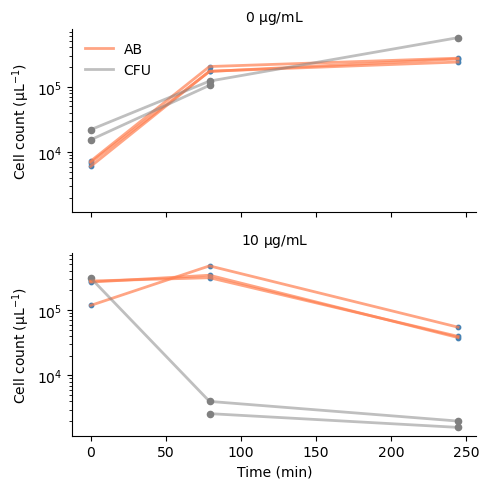

In [5]:
fig,ax_list = plt.subplots(nrows=2,ncols=1,figsize=(5,5),sharex=True,sharey=True)
ax_list = ax_list.flatten()

row_indx = 0
for key in cell_count_mean.keys():
    ax = ax_list[row_indx]
    cell_count_t = cell_count_raw[key]

    for i in range(3):
        ax.scatter(time,cell_count_t[i,:],color='steelblue',alpha=1,s=10)
        ax.plot(time,cell_count_t[i,:],color='coral',alpha=0.7,linewidth=2,label='AB')
        
    # ax.errorbar(time,cell_count_mean[key],yerr=cell_count_err[key],fmt='o',label=key)
    # ax.scatter(time,mean_dict[key],label=key)
    # ax.set_xscale('log')
    ax.set_title(str(key) + ' $\mathrm{\mu}$g/mL',fontsize=10)
    ax.set_yscale('log')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    row_indx += 1

# ax_list[0].plot(time,ctx0_mean,color='black',linewidth=2)

for key in ctx0_raw.keys():
    ax_list[0].scatter(time,ctx0_raw[key],color='gray',alpha=1,s=20)
    ax_list[0].plot(time,ctx0_raw[key],color='gray',alpha=0.5,linewidth=2,label='CFU')

for key in ctx10_raw.keys():
    ax_list[1].scatter(time,ctx10_raw[key],color='gray',alpha=1,s=20)
    ax_list[1].plot(time,ctx10_raw[key],color='gray',alpha=0.5,linewidth=2,label='CFU')

# plot only unique legend entries
    
handles, labels = ax_list[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax_list[0].legend(by_label.values(), by_label.keys(),frameon=False)

ax_list[1].set_xlabel('Time (min)')

for ax in ax_list:
    ax.set_ylabel('Cell count ($\mathrm{\mu}$L$^{-1}$)')

fig.tight_layout()

fig.savefig('../../figures/time_kill_11092023_cell_count.pdf',bbox_inches='tight')

In [8]:
np.mean([2600,4000])

3300.0

In [9]:
cell_count_mean

{0: array([  6729.34220571, 182711.12198011, 259668.35413833]),
 10: array([221028.12961867, 375758.40952344,  44044.55531351])}